In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import os
#print(os.listdir('../input/'))
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
batch_size = 8
image_size = 128
epochs = 5

In [4]:
class Datagen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=batch_size, image_size=image_size):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
    
    def Load_img(self, each_id):
        each_img_path = os.path.join(self.path, each_id, 'images', each_id) + '.png'
        mask_path = os.path.join(self.path, each_id, 'masks/')
        all_masks = os.listdir(mask_path)
        
        image = cv2.imread(each_img_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        # creating an empty mask which will hold all the masks combined
        mask = np.zeros((self.image_size,self.image_size,1)) #its a grayscale mask
        
        for each_mask in all_masks:
            each_mask_path = os.path.join(mask_path, each_mask)
            # reading each mask and resizing it
            each_mask_image = cv2.imread(each_mask_path, -1)
            each_mask_image = cv2.resize(each_mask_image, (self.image_size,self.image_size))
            each_mask_image = np.expand_dims(each_mask_image, axis=-1)
            # combining each mask of every image into 1
            mask = np.maximum(mask, each_mask_image)
            
        # normalizing each image and its mask
        image, mask = image/255.0, mask/255.0
        return image, mask
        
    
    def __getitem__(self, batch_idx):
        if ((batch_idx+1)*self.batch_size) > len(self.ids):
            self.batch_size = (len(self.ids)-(batch_idx*self.batch_size))
        batch_imgs = []
        batch_masks = []
        batch_ids = self.ids[(batch_idx*self.batch_size):((batch_idx+1)*self.batch_size)]
        for each_id in batch_ids:
            each_batch_img, each_batch_mask = self.Load_img(each_id)
            batch_imgs.append(each_batch_img)
            batch_masks.append(each_batch_mask)
        batch_imgs = np.array(batch_imgs)
        batch_masks = np.array(batch_masks)
        return batch_imgs, batch_masks
    
    
    def __len__(self):
        return int(np.ceil(len(self.ids) / float(self.batch_size)))
    

In [24]:
train_path = '/Users/HOMEDRIVE/train/stage1_train/'
test_path = '/Users/HOMEDRIVE/test/stage1_test/'
total_ids = os.listdir(train_path)
total_ids.remove('.DS_Store')
# keeping 15 images for validation 
val_data_size = 15
valid_ids = total_ids[:val_data_size]
train_ids = total_ids[val_data_size:]
test_ids = os.listdir(test_path)
image_size = 128
batch_size = 8
epochs = 5

In [27]:
## defining contraction, upsampling and bridge blocks of Unet

def contractn_blk(x, no_filters, filter_size=(3,3), padding='same', strides=1):
    conv1 = keras.layers.Conv2D(no_filters, filter_size, padding=padding, strides=strides, activation='relu')(x)
    conv2 = keras.layers.Conv2D(no_filters, filter_size, padding=padding, strides=strides, activation='relu')(conv1)
    pool1 = keras.layers.MaxPool2D((2,2), (2,2))(conv2)
    return conv2, pool1

def bridge_blk(x, no_filters, filter_size=(3,3), padding='same', strides=1):
    conv1 = keras.layers.Conv2D(no_filters, filter_size, padding=padding, strides=strides, activation='relu')(x)
    conv2 = keras.layers.Conv2D(no_filters, filter_size, padding=padding, strides=strides, activation='relu')(conv1)
    return conv2

def Upsample_blk(x, skip, no_filters, filter_size=(3,3), padding='same', strides=1):
    UpSamp = keras.layers.UpSampling2D((2,2))(x)
    skip_stg = keras.layers.Concatenate()([UpSamp, skip])
    conv1 = keras.layers.Conv2D(no_filters, filter_size, padding=padding, strides=strides, activation='relu')(skip_stg)
    conv2 = keras.layers.Conv2D(no_filters, filter_size, padding=padding, strides=strides, activation='relu')(conv1)
    return conv2
    

In [28]:
### defining Unet
def Unet():
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    x = inputs
    conv_output = {}
    pool_output = {}
    no_filters = 16
    no_layers_contractn = 4
    for i in range(no_layers_contractn):
        conv, pool = contractn_blk(x, ((2**i)*no_filters))
        conv_output['c'+str(i+1)] = conv
        pool_output['p'+str(i+1)] = pool
        x = pool
    
    conv_output['c'+str(no_layers_contractn+1)] = bridge_blk(pool_output['p'+str(no_layers_contractn)], (2**(no_layers_contractn))*no_filters)
    
    x = conv_output['c'+str(no_layers_contractn+1)]
    for i in range(no_layers_contractn-1, -1, -1):
        skip = conv_output['c'+str(i+1)]
        conv = Upsample_blk(x, skip, (2**i)*no_filters)
        x = conv
    
    outputs = keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)
    model = keras.models.Model(inputs, outputs)
    return model

In [29]:
#model = Unet(no_filters_first_layer, no_layers_contractn)
model = Unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [30]:
train_gen = Datagen(train_ids, train_path, batch_size, image_size)
train_steps = (len(train_ids)//batch_size)
valid_gen = Datagen(valid_ids, train_path, batch_size, image_size)
valid_steps = (len(valid_ids)//batch_size)

In [31]:
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
81/81 [==============================] - 130s 2s/step - loss: 0.4088 - acc: 0.8428 - val_loss: 0.3692 - val_acc: 0.8192
Epoch 2/5
81/81 [==============================] - 143s 2s/step - loss: 0.2320 - acc: 0.8629 - val_loss: 0.1644 - val_acc: 0.9183
Epoch 3/5
81/81 [==============================] - 178s 2s/step - loss: 0.1559 - acc: 0.9241 - val_loss: 0.1748 - val_acc: 0.9054
Epoch 4/5
81/81 [==============================] - 157s 2s/step - loss: 0.1194 - acc: 0.9384 - val_loss: 0.1015 - val_acc: 0.9447
Epoch 5/5
81/81 [==============================] - 165s 2s/step - loss: 0.1036 - acc: 0.9435 - val_loss: 0.1467 - val_acc: 0.9211


In [32]:
#test_gen = Datagen(test_ids, test_path, batch_size, image_size)
test_steps = len(test_ids)//batch_size

In [33]:
test_imgs = []
for i in test_ids:
    each_test_img_path = os.path.join(test_path, i, 'images', i) + '.png'
    image = cv2.imread(each_test_img_path, 1)
    image = cv2.resize(image, (image_size, image_size))
    image = image/255.0
    test_imgs.append(image)
test_imgs = np.array(test_imgs)

In [34]:
print(test_imgs.shape)

(65, 128, 128, 3)


In [35]:
result = model.predict(test_imgs)
## converting mask to binary image
result = result > 0.5
result = result * 255.0

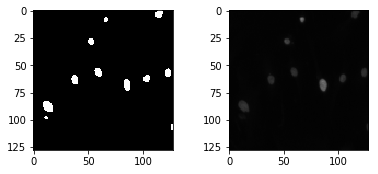

In [36]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(test_imgs[0])